# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Изучение данных

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
autos = pd.read_csv('/datasets/autos.csv')

In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете присутствуют пропуски в данных с типом "object"

In [5]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В датасете требуется обработка выбросов:
Price - целевой признак (не может ровняться 0 и слишком большое максимальное значение)
RegistrationYear - год выпуска, значительный признак (вероятно, 1000 и 9999 год это опечатки)
Power - самый значимый признак по корреляции с ценой (таблица ниже), равной 0 и 20 000 вероятно быть не может. 

In [7]:
autos.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Наибольшее влияние на цену оказывает количество лошадей(прямая зависимость) и пробег(обратная зависимость)

In [8]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Обработка пропусков: \
VehicleType - тип кузова, поскольку признак категорией, можно создать новую категорию "не указано"\
Gearbox - тип коробки передач - важный показатель, наличие автоматической коробки (и ее аналогов) увеличивает стоимость автомобиля, при продаже этот признак не указывали, поскольку не акцентировали на этом внимание, предлагаю рискнуть и заменить пропущенные значение на механическую коробку передач\
Model - без указания модели сложно предположить как это скажется на обучении модели. введем категорию "не указано" (или удалить!!)\
FuelType - тип топлива - дизель и газ наименее популярен у легковых машин, думаю, лучше заполнить пропуски "бензин"\
Repaired - была машина в ремонте, поскольку не указано, лучше ввести "не указано"\

Для модели прогноза не представляют интереса следующие столбцы:\
DateCrawled\
RegistrationMonth \
DateCreated\
PostalCode\
LastSeen\
NumberOfPictures - в датасете одни нули\

### Проверка дубликатов, удаление столбцов

In [9]:
autos.duplicated().sum()

4

In [10]:
autos = autos.drop_duplicates()

4 но все равно есть =)

In [11]:
del_col = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 
           'LastSeen', 'NumberOfPictures']
autos = autos.drop(del_col, axis=1)

In [12]:
autos.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


### Обработка пропусков

в категориях с пропусками, где необходимо добавим категорию "not_ind"

In [13]:
columns_not_ind = ['VehicleType', 'Model', 'Repaired']

In [14]:
for a in columns_not_ind:
    print(autos[a].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 

VehicleType - пропуски заменим на "other"\
Model -  пропуски удалим\
Repaired - пропуски укажем "not_ind"

In [15]:
autos['VehicleType'] = autos['VehicleType'].fillna('other')
autos = autos.dropna (subset=['Model'])
autos['Repaired'] = autos['Repaired'].fillna('not_ind')

In [16]:
columns_not_ind2 = ['Gearbox', 'FuelType']

In [17]:
for a in columns_not_ind2:
    print(autos[a].unique())

['manual' 'auto' nan]
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [18]:
for a in columns_not_ind2:
    print(autos.groupby(a)[a].count())

Gearbox
auto       63036
manual    255922
Name: Gearbox, dtype: int64
FuelType
cng            544
electric        66
gasoline     95856
hybrid         208
lpg           4962
other          133
petrol      207159
Name: FuelType, dtype: int64


Gearbox - заполним "manual"
FuelType - заполним "petrol"

In [19]:
autos['Gearbox'] = autos['Gearbox'].fillna('manual')
autos['FuelType'] = autos['FuelType'].fillna('petrol')

In [20]:
autos.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

на данный момент удалено 19709 строк

### Обработка выбросов

In [21]:
miss = ['Price', 'Power', 'RegistrationYear']
autos[miss].describe()

,Price,Power,RegistrationYear
count,334660.000000,334660.000000,334660.000000
mean,4504.372249,111.372659,2003.924024
std,4531.457109,185.157391,69.377633
min,0.000000,0.000000,1000.000000
25%,1150.000000,70.000000,1999.000000
50%,2800.000000,105.000000,2003.000000
75%,6500.000000,143.000000,2008.000000
max,20000.000000,20000.000000,9999.000000


<AxesSubplot:>

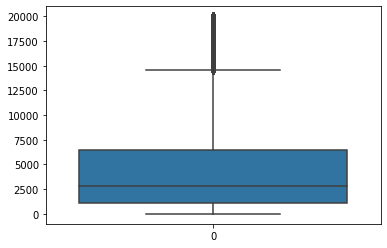

In [22]:
sns.boxplot(data = autos['Price'])

<AxesSubplot:>

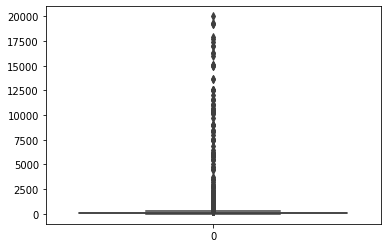

In [23]:
sns.boxplot(data = autos['Power'])

<AxesSubplot:>

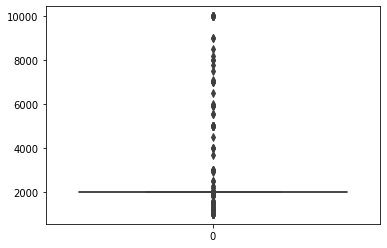

In [24]:
sns.boxplot(data = autos['RegistrationYear'])

In [25]:
a = autos['RegistrationYear'].unique()
a.sort()
a

array([1000, 1001, 1111, 1200, 1234, 1300, 1400, 1500, 1600, 1602, 1800,
       1910, 1919, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1941, 1942, 1943, 1945, 1947, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2290, 2500, 2900, 3000, 3700, 4000,
       4500, 5000, 5555, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800,
       8000, 8200, 8500, 9000, 9999])

Обработку выбросов будем проводить следующим образом: \
Price оставляем данные от 100 до 17000\
Power оставляем данные от 40 до 2000\
RegistrationYear оставляем данные от 1910 до 2016

In [26]:
autos1 = autos[(autos['Price'] >= 100) & (autos['Price'] <= 17000)]
autos1 = autos1[(autos1['Power'] >= 40) & (autos1['Power'] <= 2000)]
autos1 = autos1[(autos1['RegistrationYear'] >= 1910) & (autos1['RegistrationYear'] <= 2016)]


In [27]:
autos1.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,not_ind
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [28]:
autos1['RegistrationYear'].unique()

array([2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007, 2009, 2002,
       1997, 1990, 1981, 2003, 1991, 1984, 2006, 1999, 2012, 2010, 2000,
       1992, 2013, 1994, 1996, 1989, 2011, 2015, 1993, 1985, 1982, 1983,
       1973, 1969, 1971, 1987, 1988, 1980, 1986, 1965, 1945, 1974, 1978,
       1976, 1979, 1972, 1977, 1970, 1963, 1966, 1961, 1975, 1960, 1910,
       1968, 1967, 1949, 1959, 1953, 1958, 1962, 1964, 1955, 1951, 1950,
       1942, 1957, 1956, 1943, 1938, 1928, 1954, 1931, 1927, 1937])

In [29]:
autos1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276316 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             276316 non-null  int64 
 1   VehicleType       276316 non-null  object
 2   RegistrationYear  276316 non-null  int64 
 3   Gearbox           276316 non-null  object
 4   Power             276316 non-null  int64 
 5   Model             276316 non-null  object
 6   Kilometer         276316 non-null  int64 
 7   FuelType          276316 non-null  object
 8   Brand             276316 non-null  object
 9   Repaired          276316 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.2+ MB


In [30]:
(autos['Price'].count() - autos1['Price'].count()) / autos['Price'].count()

0.1743381342257814

в ходе подготовки данных удалено 19 % данных, что является большим значением, но приемлемым. 

В ходе подготовки данных было выполнено: 
1. Изучены дынные: наибольший влияющий фактор на цену — это мощность и пробег
2. Обработаны пропуски:
VehicleType – пропуски заменили на категорию другие
Gearbox -  пропуски заменили на механический тип
Model – пропуски удалили
FuelType – пропуски заполнили на бензин
Repaired – заполнили как не указано
Удалены следующие столбцы: DateCrawled RegistrationMonth DateCreated PostalCode LastSeen NumberOfPictures 
3. Удалены дубликаты
4. Проведена обработка выбросов:
Price оставляем данные от 100 до 17000
Power оставляем данные от 40 до 2000
RegistrationYear оставляем данные от 1910 до 2019


Подготовленные данные составляют 81 % от исходных


## Обучение моделей

Для обучения были выбраны следующие модели: 
1. случайный лес
2. LightGBM
3. CatBoostRegressor

In [31]:
autos1['Model'].value_counts()

golf                  24101
other                 19470
3er                   16874
polo                  10580
corsa                 10009
astra                  9022
passat                 8619
a4                     8510
c_klasse               7003
5er                    6821
e_klasse               5681
a3                     5054
focus                  5005
a6                     4778
fiesta                 4755
2_reihe                4347
transporter            3894
fortwo                 3775
twingo                 3699
vectra                 3468
a_klasse               3337
1er                    3084
mondeo                 2995
3_reihe                2963
clio                   2817
touran                 2806
punto                  2618
zafira                 2491
megane                 2339
ibiza                  2321
lupo                   2119
ka                     2028
fabia                  1881
octavia                1864
cooper                 1643
clk                 

In [32]:
target = autos1['Price']
autos2 = autos1.drop('Price', axis = 1)
autos_light = autos2
autos_light = autos_light.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "Repaired":'category',
                                  "Model":'category'})

In [33]:
features_train_l, features_test_l, target_train_l, target_test_l = train_test_split(
    autos_light, target, test_size = 0.25, random_state = 12345)

In [34]:
features_train, features_test, target_train, target_test = train_test_split(
    autos2, target, test_size = 0.25, random_state = 12345)
print('Размер обучающей выборки', features_train.shape[0], f'{  features_train.shape[0]/autos1.shape[0]:.1%}')
print('Размер  валидационной выборки', features_test.shape[0], f'{  features_test.shape[0]/autos1.shape[0]:.1%}')

Размер обучающей выборки 207237 75.0%
Размер  валидационной выборки 69079 25.0%


In [35]:
encoder = OrdinalEncoder()
categ = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']

features = autos2[categ]
features = pd.DataFrame(encoder.fit_transform(features),
                        columns=features.columns, index=features.index) 
autos3 = autos2
for column in categ:
    autos3[column] = features[column]

Было принято решение провести кодировку до разбития на выборки, поскольку при анализе столбца "Model" было выявлено, что некоторые значения категориальных признаков встречаются редко и могут попасть только в тестовую выборку.

In [36]:
features_train_OE, features_test_OE, target_train_OE, target_test_OE = train_test_split(
    autos3, target, test_size = 0.25, random_state = 12345)

In [37]:
params_RFR = {'n_estimators': [50, 70, 100], 'max_depth': [ 1, 5, 10]}

#RFR = GridSearchCV(estimator = RandomForestRegressor(), param_grid = params_RFR, cv=5, n_jobs=-1, verbose=1)
#RFR.fit(features_train_OE, target_train_OE)


In [38]:
#RFR.best_params_

Для случайного леса были определены следующие параметры\
(random_state=12345, n_estimators=100, max_depth=10)

In [39]:
%%time
RFR = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=10)
RFR.fit(features_train_OE, target_train_OE)

CPU times: user 26 s, sys: 77.2 ms, total: 26.1 s
Wall time: 26.1 s


RandomForestRegressor(max_depth=10, random_state=12345)

In [40]:
%%time
predictions_RFR = RFR.predict(features_train_OE)

CPU times: user 1.76 s, sys: 16.1 ms, total: 1.78 s
Wall time: 1.79 s


In [41]:
result_RFR = mean_squared_error(target_train_OE, predictions_RFR)**0.5 
result_RFR

1619.3384675910095

In [42]:
def RMSE(model, features, target): 
    a = cross_val_score(model, features, target, cv=3, scoring='neg_mean_squared_error') 
    final_score = abs(sum(a) / len(a)) ** 0.5
    return final_score

In [43]:
result_RFR_cv = RMSE(RFR, features_train_OE, target_train_OE)

In [44]:
result_RFR_cv

1677.746954216984

In [45]:
params_cat = {'iterations': [100], 'depth':[x for x in range (2,16,2)]}

#cat = GridSearchCV(estimator = CatBoostRegressor(random_state=1234),
#    param_grid = params_cat, cv=2, verbose=False, n_jobs=-1)
#cat.fit(features_train_OE, target_train_OE)

In [46]:
#cat.best_params_

Для CatBoostRegressor были определены следующие гиперпараметры: 
(iterations = 100, depth = 12,  verbose=False)

In [47]:
CatBoost = CatBoostRegressor(iterations = 100, depth = 12,  verbose=False)

In [48]:
%%time
CatBoost.fit(features_train_OE, target_train_OE)

CPU times: user 8.83 s, sys: 72.1 ms, total: 8.9 s
Wall time: 9.41 s


In [49]:
%%time
predictions_cat = CatBoost.predict(features_train_OE)

CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 112 ms


In [50]:
result_cat = mean_squared_error(target_train_OE, predictions_cat)**0.5 

In [51]:
result_cat

1231.4696599468716

In [52]:
result_cat_cv = RMSE(CatBoost, features_train_OE, target_train_OE)

In [53]:
result_cat_cv

1428.9413850755284

In [54]:
lgb_reg = lgb.LGBMRegressor()
param = {
    'num_leaves': [31, 100],
    'random_state': [12345],
    'n_estimators': [100, 150]
    }

#LGBMR1 = GridSearchCV(estimator = lgb_reg, param_grid = param, cv=2)

#LGBMR1.fit(features_train_l, target_train_l)

#print(LGBMR1.best_params_)

для LGBMRegressor были определены следующие параметры
{'n_estimators': 150, 'num_leaves': 100, 'random_state': 12345}

In [55]:
%%time
LGBMR = lgb.LGBMRegressor(num_leaves = 100,
                          n_estimators = 150, random_state = 12345)
LGBMR.fit(features_train_l, target_train_l)

CPU times: user 11.7 s, sys: 168 ms, total: 11.8 s
Wall time: 12 s


LGBMRegressor(n_estimators=150, num_leaves=100, random_state=12345)

In [56]:
%%time
predictions_LGBMR = LGBMR.predict(features_test_l)

CPU times: user 1.35 s, sys: 8.06 ms, total: 1.36 s
Wall time: 1.4 s


In [57]:
result_LGBMR = mean_squared_error(target_test_l, predictions_LGBMR)**0.5 

In [58]:
result_LGBMR

1383.2149161178997

In [59]:
result_LGBMR_cv = RMSE(LGBMR, features_train_l, target_train_l)

In [60]:
result_LGBMR_cv

1391.7965728726513

На выходе получаем 3 модели:\
RFR - случайный лес (n_estimators=100, max_depth=10)\
LGBMR - LightGBM (n_estimators': 150, 'num_leaves': 100)\
cat - CatBoostRegressor (iterations = 100, depth = 12)

## Анализ моделей

In [61]:
summ = pd.DataFrame(
    {'RMSE': [result_cat, result_LGBMR, result_RFR],
     'RMSE_cv': [result_cat_cv, result_LGBMR_cv, result_RFR_cv],
     'Time_fit': [10.1, 11.6, 27.8],
     'Time_predict': [0.1, 1.42, 1.82]},
    index = ['CatBoost', 'LightGBM', 'RFR'])
summ

,RMSE,RMSE_cv,Time_fit,Time_predict
CatBoost,1231.469660,1428.941385,10.1,0.10
LightGBM,1383.214916,1391.796573,11.6,1.42
RFR,1619.338468,1677.746954,27.8,1.82


Исходя из полученых данных у модели случайного леса показатели времени и качество предсказаний хуже. эта модель сильно уступает\
Значения метрики моделей CatBoost и LightGBM приблизительно одинаковые. CatBoost чуть быстрее, LightGBM лучше предсказывает. \
Поскольку для заказчика время важнее выбираем CatBoost. 

# Тестирование лучшей модели

 для прогноза была выбрана модель CatBoostRegressor со следующими гиперпараметрами (iterations = 100, depth = 12,  verbose=False)

In [62]:
%%time
CatBoost = CatBoostRegressor(iterations = 100, depth = 12,  verbose=False)
CatBoost.fit(features_train_OE, target_train_OE)

CPU times: user 8.4 s, sys: 27.2 ms, total: 8.43 s
Wall time: 8.86 s


In [63]:
%%time
predictions_cat = CatBoost.predict(features_test_OE)

CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 37.4 ms


In [64]:
result_cat_cv = RMSE(CatBoost, features_test_OE, target_test_OE)
result_cat_cv

1517.749930506367

 Результаты выбранной модели (CatBoostRegressor) на тестовой выборке:\
    1. качество предсказания- RMSE = 1517.7\
    2. время обучения модели- 9.2 c\
    3. время предсказания модели - 0.035 c


### Общий вывод

1. В ходе подготовки данных было выполнено:
Изучены дынные: наиболее влияющий фактор на цену — это мощность и пробег\
Обработаны пропуски: VehicleType – пропуски заменили на категорию другие\
Gearbox - пропуски заменили на механический тип Model – пропуски удалили\
FuelType – пропуски заполнили на бензин Repaired – заполнили как не указано\
Удалены следующие столбцы: DateCrawled RegistrationMonth DateCreated PostalCode LastSeen NumberOfPictures\
Удалены дубликаты\
Проведена обработка выбросов: Price оставляем данные от 100 до 17000 Power оставляем данные от 40 до 2000 RegistrationYear оставляем данные от 1910 до 2019
2. В ходе кодирования данных было выполнено:
Для моделей случайного леса и CatBoost применили методику OrdinalEncoder
Для модели LightGBM ввели тип данных категорий
Провели разбивку данных на 75 % для обучения и 25 % для теста
3. Было изучено и подобраны гиперпараметры для случайного леса, CatBoost и  LightGBM.В ходе анализа моделей была выбрана модель CatBoost (с гиперпараметрами (n_estimators': 150, 'num_leaves': 100) с метрикой RMSE = 1453, с общим временем обучения и предсказания 10,5 с. 
4. Результаты выбранной модели (CatBoostRegressor) на тестовой выборке: качество предсказания- RMSE = 1517.7; время обучения модели- 9.2 c; время предсказания модели - 0.035 c